# 模型优化 v1

## 训练集数据预处理

In [1]:
import pandas as pd
import numpy as np
from pandas import Series,DataFrame
import matplotlib.pyplot as plt  
import re
from sklearn import model_selection

data_train = pd.read_csv("train.csv")

In [2]:
def set_Cabin_type(df):
    df.loc[ (df.Cabin.notnull()), 'Cabin' ] = "Yes"
    df.loc[ (df.Cabin.isnull()), 'Cabin' ] = "No"
    return df


In [3]:
# 补全Cabin`
set_Cabin_type(data_train)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,No,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,Yes,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,No,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,Yes,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,No,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,No,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,Yes,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,No,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,No,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,No,C


In [4]:
# what is each person's title? 
data_train['Title'] = data_train['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])

# 将各式称呼进行统一化处理：
title_Dict = {}
title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
title_Dict.update(dict.fromkeys(['Mr','Jonkheer'], 'Mr'))
title_Dict.update(dict.fromkeys(['Master'], 'Master'))
data_train['Title'] = data_train['Title'].map(title_Dict)

# #使用dummy对不同的称呼进行分列：
dummies_Title = pd.get_dummies(data_train['Title'], prefix= 'Title')
data_train = pd.concat([data_train, dummies_Title], axis=1)
#data_train

In [5]:
# 补全Age
dict = (data_train.pivot_table(index='Title', aggfunc = 'mean')).Age.to_dict()
data_train.loc[data_train.Age.isnull(), 'Age'] = data_train[data_train.Age.isnull()].Title.map(dict)

In [6]:
# add Child
data_train['Child'] = (data_train.Age < 12) + 0

# add Mother
data_train['Mother'] = ((data_train.Title_Mrs==1 + (data_train.Parch > 1)) > 0 ) + 0

# add family size
data_train['Family'] = data_train.Parch + data_train.SibSp
#data_train.info()

In [7]:
import sklearn.preprocessing as preprocessing
# 完成Age与Fare的归一化
scaler = preprocessing.StandardScaler()

age_scale_param = scaler.fit(np.array(data_train.Age).reshape(-1,1))
data_train['Age_scaled'] = scaler.fit_transform(np.array(data_train.Age).reshape(-1,1), age_scale_param)

fare_scale_param = scaler.fit(np.array(data_train.Fare).reshape(-1,1))
data_train['Fare_scaled'] = scaler.fit_transform(np.array(data_train.Fare).reshape(-1,1), fare_scale_param)
#data_train.info()

In [8]:
dummies_Cabin = pd.get_dummies(data_train['Cabin'], prefix= 'Cabin')
dummies_Embarked = pd.get_dummies(data_train['Embarked'], prefix= 'Embarked')
dummies_Sex = pd.get_dummies(data_train['Sex'], prefix= 'Sex')
dummies_Pclass = pd.get_dummies(data_train['Pclass'], prefix= 'Pclass')

df = pd.concat([data_train, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)
df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Title'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 27 columns):
PassengerId      891 non-null int64
Survived         891 non-null int64
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Title_Master     891 non-null uint8
Title_Miss       891 non-null uint8
Title_Mr         891 non-null uint8
Title_Mrs        891 non-null uint8
Title_Officer    891 non-null uint8
Title_Royalty    891 non-null uint8
Child            891 non-null int64
Mother           891 non-null int64
Family           891 non-null int64
Age_scaled       891 non-null float64
Fare_scaled      891 non-null float64
Cabin_No         891 non-null uint8
Cabin_Yes        891 non-null uint8
Embarked_C       891 non-null uint8
Embarked_Q       891 non-null uint8
Embarked_S       891 non-null uint8
Sex_female       891 non-null uint8
Sex_male         891 non-null uint8
Pclass_1         891 no

### 计算交叉验证集 

In [9]:
# 简单看看打分情况
from sklearn import model_selection
from sklearn import linear_model
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_scaled|Carbin_*|Sex_*|Pclass_*|Title_*|Child|Family|Mother')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
Survived         891 non-null int64
SibSp            891 non-null int64
Parch            891 non-null int64
Title_Master     891 non-null uint8
Title_Miss       891 non-null uint8
Title_Mr         891 non-null uint8
Title_Mrs        891 non-null uint8
Title_Officer    891 non-null uint8
Title_Royalty    891 non-null uint8
Child            891 non-null int64
Mother           891 non-null int64
Family           891 non-null int64
Age_scaled       891 non-null float64
Fare_scaled      891 non-null float64
Sex_female       891 non-null uint8
Sex_male         891 non-null uint8
Pclass_1         891 non-null uint8
Pclass_2         891 non-null uint8
Pclass_3         891 non-null uint8
dtypes: float64(2), int64(6), uint8(11)
memory usage: 65.3 KB


进行K折交叉验证

In [10]:
X = train_df.values[:,1:]
y = train_df.values[:,0]

# k折交叉验证
# 验证某个模型在某个训练集上的稳定性，输出cv=k个预测精度
# 把初始训练样本分成k份，其中（k-1）份被用作训练集，剩下一份被用作评估集，这样一共可以对分类器做k次训练，并且得到k个训练结果。
print(model_selection.cross_val_score(clf, X, y, cv=5))

[ 0.82681564  0.82122905  0.79775281  0.79213483  0.8700565 ]


### 用全部训练集来训练一个模型 

In [11]:
# fit到RandomForestRegressor之中
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
clf.fit(X, y)

clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=1e-06,
          verbose=0, warm_start=False)

In [12]:
predictions = clf.predict(X)
result = (predictions.reshape(-1,1) == y.reshape(-1,1))
sum(result)

array([740])

In [13]:
from sklearn import metrics
print("accuracy:", metrics.accuracy_score(y, predictions, normalize=True, sample_weight=None))
print("recall:", metrics.recall_score(y, predictions, labels=None, pos_label=1, average='binary', sample_weight=None))
print("precision:", metrics.precision_score(y, predictions, labels=None, pos_label=1, average='binary', sample_weight=None))#origin_data_train = pd.read_csv("/Users/HanXiaoyang/Titanic_data/Train.csv")
pd.DataFrame({"columns":list(train_df.columns)[1:], "coef":list(clf.coef_.T)})

accuracy: 0.830527497194
recall: 0.736842105263
precision: 0.805111821086


,columns,coef
0,SibSp,[-0.187529965302]
1,Parch,[0.0]
2,Title_Master,[2.4591294853]
3,Title_Miss,[0.0]
4,Title_Mr,[-0.583170616946]
5,Title_Mrs,[0.782556920248]
6,Title_Officer,[-0.100806246621]
7,Title_Royalty,[0.0]
8,Child,[0.100460130844]
9,Mother,[0.0]


### 学习曲线

In [14]:
#learning curve
from sklearn.model_selection import learning_curve

def plot_learning_curv(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,
                      train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    
    train_size, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    
    print(train_scores)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(u"训练样本数")
        plt.ylabel(u"得分")
        #plt.gca().invert_yaxis()
        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"训练集上得分")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"交叉验证集上得分")

        plt.legend(loc="best")

        plt.draw()
        plt.show()
        #plt.gca().invert_yaxis()

    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff

[[ 0.89655172  0.82758621  0.82758621]
 [ 0.91525424  0.88135593  0.88135593]
 [ 0.8988764   0.82022472  0.82022472]
 [ 0.88135593  0.8220339   0.8220339 ]
 [ 0.86486486  0.81756757  0.81756757]
 [ 0.83707865  0.84831461  0.84831461]
 [ 0.84541063  0.84541063  0.84541063]
 [ 0.84810127  0.83966245  0.83966245]
 [ 0.83895131  0.83146067  0.83146067]
 [ 0.8277027   0.81418919  0.82094595]
 [ 0.83435583  0.79754601  0.82208589]
 [ 0.83426966  0.80617978  0.83146067]
 [ 0.8238342   0.81088083  0.84196891]
 [ 0.82891566  0.81927711  0.83373494]
 [ 0.83146067  0.82022472  0.83595506]
 [ 0.83368421  0.81684211  0.82947368]
 [ 0.83928571  0.81944444  0.83333333]
 [ 0.84082397  0.82397004  0.83520599]
 [ 0.83333333  0.82801418  0.83510638]
 [ 0.83670034  0.83164983  0.83164983]]


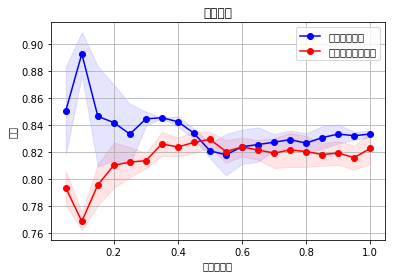

(0.82346985483522683, 0.024488618822385178)

In [15]:
plot_learning_curv(clf, u"学习曲线", X, y, cv=3)

## 开始预测

对测试集做相同的处理

其实应该和训练集一起初始化,在最开始同时处理，可以更加逼近真实值

### 测试集数据预处理

In [16]:
# 接着我们对test_data做和train_data中一致的特征变换
data_test = pd.read_csv("./test.csv")

# 补全票价 Fare
data_test.loc[ (data_test.Fare.isnull()), 'Fare' ] = data_test.Fare[data_test.Cabin.notnull()].mean()

#　补全船舱 Cabin
data_test = set_Cabin_type(data_test)

# 将各式称呼进行统一化处理：
data_test['Title'] = data_test['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])
title_Dict = {}
title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
title_Dict.update(dict.fromkeys(['Mr','Jonkheer'], 'Mr'))
title_Dict.update(dict.fromkeys(['Master'], 'Master'))
data_test['Title'] = data_test['Title'].map(title_Dict)

# #使用dummy对不同的称呼进行分列：
dummies_Title = pd.get_dummies(data_test['Title'], prefix= 'Title')
data_test = pd.concat([data_test, dummies_Title], axis=1)

# 补全Age
dict = (data_test.pivot_table(index='Title', aggfunc = 'mean')).Age.to_dict()
data_test.loc[data_test.Age.isnull(), 'Age'] = data_test[data_test.Age.isnull()].Title.map(dict)

# add Child
data_test['Child'] = (data_test.Age < 12) + 0

# add Mother
data_test['Mother'] = ((data_test.Title_Mrs==1 + (data_test.Parch > 1)) > 0 ) + 0

# add family size
data_test['Family'] = data_test.Parch + data_test.SibSp
#data_test.info()


In [17]:
import sklearn.preprocessing as preprocessing
# 完成Age与Fare的归一化
scaler = preprocessing.StandardScaler()

age_scale_param = scaler.fit(np.array(data_test.Age).reshape(-1,1))
data_test['Age_scaled'] = scaler.fit_transform(np.array(data_test.Age).reshape(-1,1), age_scale_param)

fare_scale_param = scaler.fit(np.array(data_test.Fare).reshape(-1,1))
data_test['Fare_scaled'] = scaler.fit_transform(np.array(data_test.Fare).reshape(-1,1), fare_scale_param)


In [18]:
dummies_Cabin = pd.get_dummies(data_test['Cabin'], prefix= 'Cabin')
dummies_Embarked = pd.get_dummies(data_test['Embarked'], prefix= 'Embarked')
dummies_Sex = pd.get_dummies(data_test['Sex'], prefix= 'Sex')
dummies_Pclass = pd.get_dummies(data_test['Pclass'], prefix= 'Pclass')

df = pd.concat([data_test, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)

test_df = df.filter(regex='Age_.*|SibSp|Parch|Fare_.*|Carbin_.*|Sex_.*|Pclass_.*|Title_.*|Child|Mother|Family')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 18 columns):
SibSp            418 non-null int64
Parch            418 non-null int64
Title_Master     418 non-null uint8
Title_Miss       418 non-null uint8
Title_Mr         418 non-null uint8
Title_Mrs        418 non-null uint8
Title_Officer    418 non-null uint8
Title_Royalty    418 non-null uint8
Child            418 non-null int64
Mother           418 non-null int64
Family           418 non-null int64
Age_scaled       418 non-null float64
Fare_scaled      418 non-null float64
Sex_female       418 non-null uint8
Sex_male         418 non-null uint8
Pclass_1         418 non-null uint8
Pclass_2         418 non-null uint8
Pclass_3         418 non-null uint8
dtypes: float64(2), int64(5), uint8(11)
memory usage: 27.4 KB


开始预测

In [19]:
predictions = clf.predict(test_df)
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].values, 'Survived':predictions.astype(np.int32)})
result.to_csv("./logistic_regression_predictions_v1.csv", index=False)

## 模型融合　Model Ensembling

In [42]:
from sklearn.ensemble import BaggingRegressor

# fit到BaggingRegressor之中
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
bagging_clf = BaggingRegressor(clf, n_estimators=20, max_samples=0.8, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
bagging_clf.fit(X, y)

# 使用模型融合后的模型进行预测
predictions = bagging_clf.predict(test_df)
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].values, 'Survived':predictions.astype(np.int32)})
result.to_csv("./logistic_regression_bagging_predictions_v1.csv", index=False)

## V1 For Now

　**v1版优化内容**
* 增加了Child, Mother, Family字段
* 合理的补全了测试集的缺失Fare
* 进行了Learning Curve分析
* 使用了模型融合
* Code Style

> v2版的研究方向：
> * 测试集、训练集数据共同处理
> * 分析模型系数(Miss和Child为什么是０)
> * 票价和船舱的关系联系起来